# PALM with N terms

This notebook implements an example of generalized PALM with N terms:

$$
\mathbf{x} = \argmin_{\mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_N}
\sum_i f_i(\mathbf{x}_i) + H(\mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_N)
$$

where $f_i(\mathbf{x}_i)$ are convex functions that have known 
proximal operators, and $H(\mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_N)$ 
is a nonlinear smooth function (that is however linear in each term when the other are fixed).

Note however that for the moment the generalized PALM solver is used for a canonical example of 2 terms.


In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import time
import itertools
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *

from pyproximal.proximal import *
from pyproximal.utils.bilinear import LowRankFactorizedMatrix as pyproxLowRankFactorizedMatrix
from pyproximal.optimization.palm import PALM

In [2]:
class MultiFactor():
    """MultiFactor class for handling multiple variables in a factorized manner.

    This class is designed to manage multiple variables (factors) in a matrix 
    completion or similar optimization problem. It allows for the evaluation
    of a function H that depends on multiple variables, as well as the computation
    of gradients with respect to each variable.

    Note that this is currently unused, but it is a placeholder for future
    implementations where a function H is defined over multiple variables.
    """
    def __init__(self, Xs, d, Op=None):        
        self.nx = len(Xs)
        self.xs = Xs
        self.d = d
        self.Op = Op
        
    def __call__(self, xs):
        # write a code that evaluates H(x_0, x_1, ..., x_n)
        pass
    
    def gradx(self, x, ix=0):
        pass
        
    def grad(self, x):
        g = np.hstack([self.gradx(x, ix) for ix, x_ in enumerate(x)])
        return g

    def updatex(self, x, ix):
        """Update x variable (to be used to update one of the internal variables)
        """
        self.xs[ix] = x
        
    def update(self, xs):
        """Update all variables
        """
        for ix, x in enumerate(xs):
            self.updatex(x, ix)

In [3]:
class LowRankFactorizedMatrix():
    r"""Low-Rank Factorized Matrix operator

    Bilinear operator representing the L2 norm of a Low-Rank Factorized
    Matrix defined as: :math:`H(\mathbf{X}, \mathbf{Y}) =
    \frac{1}{2} \|\mathbf{Op}(\mathbf{X}\mathbf{Y}) - \mathbf{d}\|_2^2`,
    where :math:`\mathbf{X}` is a matrix of size  :math:`n \times k`,
    :math:`\mathbf{Y}` is a matrix of size :math:`k \times m`, and
    :math:`\mathbf{Op}` is a linear operator of size :math:`p \times n`.

    Parameters
    ----------
    Xs : :obj:`list`
        List of matrices, containing 
        i) Left-matrix of size :math:`n \times k`,
        ii) Right-matrix of size :math:`k \times m`
    d : :obj:`numpy.ndarray`
        Data vector
    Op : :obj:`pylops.LinearOperator`, optional
        Linear operator

    """
    def __init__(self, Xs, d, Op=None):
        X, Y = Xs[0], Xs[1]
        self.n, self.k = X.shape
        self.m = Y.shape[1]
        
        self.nx = len(Xs)
        self.xs = [X, Y]
        self.y = Y
        self.d = d
        self.Op = Op
        self.shapes = ((self.n * self.m, self.n * self.k), 
                       (self.n * self.m, self.m * self.k))

    def __call__(self, xs):
        x, y = xs[0], xs[1]
        xold = x.copy()
        self.updatex(x, 0)
        res = self.d - self._matvec(y, 1)
        self.updatex(xold, 0)
        return np.linalg.norm(res)**2 / 2.

    def _matvec(self, x, ix):
        if ix == 0:
            X = x.reshape(self.n, self.k)
            X = X @ self.xs[1].reshape(self.k, self.m)
            if self.Op is not None:
                X = self.Op @ X.ravel()
            return X.ravel()
        else:
            Y = x.reshape(self.k, self.m)
            X = self.xs[0].reshape(self.n, self.k) @ Y
            if self.Op is not None:
                X = self.Op @ X.ravel()
            return X.ravel()

    def matvec(self, x):
        if self.n == self.m:
            raise NotImplementedError('Since n=m, this method'
                                      'cannot distinguish automatically'
                                      'between _matvecx and _matvecy. '
                                      'Explicitely call either of those two methods.')
        if x.size == self.shapex[1]:
            y = self._matvec(x, 0)
        else:
            y = self._matvec(x, 1)
        return y

    def lx(self, x, ix):
        
        if ix == 0:
            Y = x[1].reshape(self.k, self.m)
            # TODO: not clear how to handle Op
            #if self.Op is not None:
            #    Y = self.Op @ X
            return np.linalg.norm(Y @ np.conj(Y).T, 'fro')
        else:
            X = np.conj(x[0].reshape(self.n, self.k))
            # TODO: not clear how to handle Op
            #if self.Op is not None:
            #    Y = self.Op.H @ Y
            return np.linalg.norm(np.conj(X).T @ X, 'fro')
        
    def gradx(self, x, ix=0):
        if ix == 0:
            r = self.d - self._matvec(x, 0)
            if self.Op is not None:
                r = (self.Op.H @ r).reshape(self.n, self.m)
            else:
                r = r.reshape(self.n, self.m)
            g = -r @ np.conj(self.xs[1].reshape(self.k, self.m).T)
            return g.ravel()
        else:
            r = self.d - self._matvec(x, 1)
            if self.Op is not None:
                r = (self.Op.H @ r.ravel()).reshape(self.n, self.m)
            else:
                r = r.reshape(self.n, self.m)
            g = -np.conj(self.xs[0].reshape(self.n, self.k).T) @ r
            return g.ravel()

    def updatex(self, x, ix):
        """Update x variable (to be used to update one of the internal variables)
        """
        self.xs[ix] = x
        
    def update(self, xs):
        """Update all variables
        """
        for ix, x in enumerate(xs):
            self.updatex(x, ix)

In [4]:
def grad_test(hop, l0, r0, delta=1e-6):
    misfit = hop([l0, r0])

    gl = hop.gradx(l0, 0)
    gr = hop.gradx(r0, 1)

    delta = 1e-6
    iqn, iqm, iqk = np.random.randint(0, n), np.random.randint(0, m), np.random.randint(0, k)
    r_or_i = np.random.randint(0,2)
    l_or_u = np.random.randint(0,2)

    if 0 == r_or_i: 
        delta1 = delta
        
    else:
        delta1 = delta*1j

    if 0 == l_or_u:    
        l0[iqn, iqk] = l0[iqn, iqk] + delta1    
        grad = gl.reshape(n, k)[iqn, iqk]
    else:
        r0[iqk, iqm] = r0[iqk, iqm] + delta1
        grad = gr.reshape(k,m)[iqk, iqm]      

    misfit_new = hop([l0, r0])
    grad_diff = (misfit_new-misfit)/delta - (grad.real if 0==r_or_i else grad.imag)
    print(f"{(misfit_new-misfit)/delta:.4f}\t-\t{grad.real if 0==r_or_i else grad.imag:.4f}\t-\t{grad_diff:.4f}")

In [5]:
def _backtracking(x, tau, H, proxf, ix, beta=0.5, niterback=10):
    r"""Backtracking

    Line-search algorithm for finding step sizes in proximal algorithms when
    the Lipschitz constant of the operator is unknown (or expensive to
    estimate).

    """
    def ftilde(x, y, f, g, tau, ix):
        xy = x - y[ix]
        return f(y) + np.dot(g, xy) + \
               (1. / (2. * tau)) * np.linalg.norm(xy) ** 2

    iiterback = 0
    grad = H.gradx(x[ix], ix)
    z = [x_.copy() for x_ in x]
    while iiterback < niterback:
        z[ix] = proxf.prox(x[ix] - tau * grad, tau)
        ft = ftilde(z[ix], x, H, grad, tau, ix)
        f = H(z)
        if f <= ft or tau < 1e-12: 
            break
        tau *= beta
        iiterback += 1
    return z[ix], tau


def GeneralizedPALM(H, proxfs, x0s, gammafs, beta=0.5, niter=10, niterback=100, 
                    acceleration=None, callback=None, show=False):
    r"""Proximal Alternating Linearized Minimization with N blocks

    Solves the following minimization problem using the Proximal Alternating
    Linearized Minimization (PALM) algorithm:

    .. math::

        \mathbf{x} = \argmin_{\mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_N}
        \sum_i f_i(\mathbf{x}_i) + H(\mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_N)

    where :math:`f_i(\mathbf{x}_i)` are convex functions that have known 
    proximal operators, and :math:`H(\mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_N)` 
    is a smooth function.

    Parameters
    ----------
    H : :obj:`pyproximal.utils.bilinear.Nlinear`
        N-linear function
    proxfs : :obj:`pyproximal.ProxOperator`
        Proximal operators of f functions
    x0s : :obj:`list`
        Initial vectors
    gammafs : :obj:`list`, optional
        List of positive weights for ``H`` functions update. If None, use backtracking
    beta : :obj:`float`, optional
        Backtracking parameter (must be between 0 and 1)
    niter : :obj:`int`, optional
        Number of iterations of iterative scheme
    niterback : :obj:`int`, optional
        Max number of iterations of backtracking
    acceleration : :obj:`str`, optional
        Acceleration (``None``, ``vandenberghe`` or ``fista``)
    callback : :obj:`callable`, optional
        Function with signature (``callback(x)``) to call after each iteration
        where ``x`` and ``y`` are the current model vectors
    show : :obj:`bool`, optional
        Display iterations log

    Returns
    -------
    xs : :obj:`numpy.ndarray`
        Inverted x vectors
    
    """
    if show:
        tstart = time.time()
        msgprox = ''.join(['Proximal operator (f%d): %s\n' for i in range(len(proxfs))])
        msg = 'Generalized PALM algorithm\n' + \
              '---------------------------------------------------------\n' + \
              'Bilinear operator: %s\n' + \
              msgprox + \
              'gammafs = %s\tniter = %d\n'
        print(msg % (type(H), *list(itertools.chain.from_iterable([(i, type(prox)) for i, prox in enumerate(proxfs)])), 
                     str(gammafs), niter))
        head = '   Itn      x[0][0]        ' + ''.join(['f%d      ' % i for i in range(len(proxfs))]) + 'H'
        print(head)
    
    nx = len(x0s)
    
    backtracking = False
    if gammafs is None:
        backtracking = True
        taus = [1., ] * nx

    # initialize model
    t = 1.
    xs = [x_.copy() for x_ in x0s]
    ys = [x_.copy() for x_ in x0s]
    
    # iterate
    for iiter in range(niter):
        for ix in range(nx):
            xold = xs[ix].copy()
            
            # proximal step
            if not backtracking:
                ck = gammafs[ix] * H.lx(ys, ix)
                xs[ix] = ys[ix] - (1. / ck) * H.gradx(ys[ix], ix)
                if proxfs[ix] is not None:
                    xs[ix] = proxfs[ix].prox(xs[ix], 1. / ck)
            else:
                xs[ix], taus[ix] = _backtracking(ys, taus[ix], H,
                                                 proxfs[ix], ix,
                                                 beta=beta, niterback=niterback)
            # update x parameter in H function
            H.updatex(xs[ix].copy(), ix)
            
            # update y
            if acceleration == 'vandenberghe':
                omega = iiter / (iiter + 3)
            elif acceleration == 'fista':
                told = t
                t = (1. + np.sqrt(1. + 4. * t ** 2)) / 2.
                omega = ((told - 1.) / t)
            else:
                omega = 0

            ys[ix] = xs[ix] + omega * (xs[ix] - xold)
            
        # run callback
        if callback is not None:
            callback(xs)

        if show:
            pfs = [proxfs[ix](xs[ix]) if proxfs[ix] is not None else 0. for ix, x in enumerate(xs)]
            if iiter < 10 or niter - iiter < 10 or iiter % (niter // 10) == 0:
                msg = str('%6g    %5.5e   ' + '%5.2e   ' * len(proxfs) + '%5.5e')  % \
                      (iiter, xs[0][0], *pfs, H(xs))
                print(msg)
    if show:
        print('\nTotal time (s) = %.2f' % (time.time() - tstart))
        print('---------------------------------------------------------\n')
    return xs

In [6]:
# Gradient test
n, m, k = 100, 90, 10
l0 = np.random.rand(n, k) + np.random.rand(n, k)*1j
r0 = np.random.rand(k, m) + np.random.rand(k, m)*1j

Xin = np.random.normal(0, 1, (n, k)) + 1j * np.random.normal(0, 1, (n, k))
Yin = np.random.normal(0, 1, (k, m)) + 1j * np.random.normal(0, 1, (k, m))
A = np.random.normal(0, 1, (n, m)) + 1j * np.random.normal(0, 1, (n, m))

hop = LowRankFactorizedMatrix([Xin.copy(), Yin.copy()], A.ravel())

for _ in range(10):
    grad_test(hop, Xin, Yin, delta=1e-6)

0.7006	-	0.7005	-	0.0001
177.3775	-	177.3774	-	0.0002
-413.8337	-	-413.8339	-	0.0001
-50.8016	-	-50.8018	-	0.0002
-193.3722	-	-193.3723	-	0.0001
-139.0713	-	-139.0713	-	0.0001
-25.7805	-	-25.7805	-	0.0000
-37.1205	-	-37.1206	-	0.0001
-187.0234	-	-187.0235	-	0.0001
-192.0269	-	-192.0270	-	0.0002


## Define problem

In [7]:
n, m, k = 100, 90, 10
X = np.random.normal(0, 1, (n, k))
Y = np.random.normal(0, 1, (k, m))
X = sp.ndimage.gaussian_filter(X, 1)
Y = sp.ndimage.gaussian_filter(Y, 1)
A = X @ Y

sub = 0.01
nsub = int(n*m*sub)
iava = np.random.permutation(np.arange(n*m))[:nsub]
Rop = Restriction(n*m, iava)

hop = LowRankFactorizedMatrix([X.copy(), Y.copy()], Rop @ A.ravel(), Rop)

Generalized PALM algorithm
---------------------------------------------------------
Bilinear operator: <class '__main__.LowRankFactorizedMatrix'>
Proximal operator (f0): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (f1): <class 'pyproximal.proximal.L2.L2'>
gammafs = [2, 2]	niter = 500

   Itn      x[0][0]        f0      f1      H
     0    2.65802e-01   3.64e+01   3.06e+01   2.16990e+04
     1    1.91088e-01   2.65e+01   2.06e+01   9.67886e+03
     2    9.78007e-02   1.75e+01   1.33e+01   3.45330e+03
     3    5.51199e-03   1.17e+01   9.08e+00   1.38691e+03
     4    -6.58765e-02   8.60e+00   6.97e+00   9.09257e+02
     5    -1.01419e-01   7.10e+00   5.98e+00   7.54213e+02
     6    -9.52427e-02   6.49e+00   5.69e+00   5.71378e+02
     7    -5.92638e-02   6.47e+00   5.89e+00   3.86527e+02
     8    -2.32523e-02   6.75e+00   6.23e+00   3.00344e+02
     9    -1.20051e-02   6.97e+00   6.42e+00   2.54212e+02
    50    -2.40627e-01   5.81e+00   6.75e+00   3.23588e+00
   100    4.2

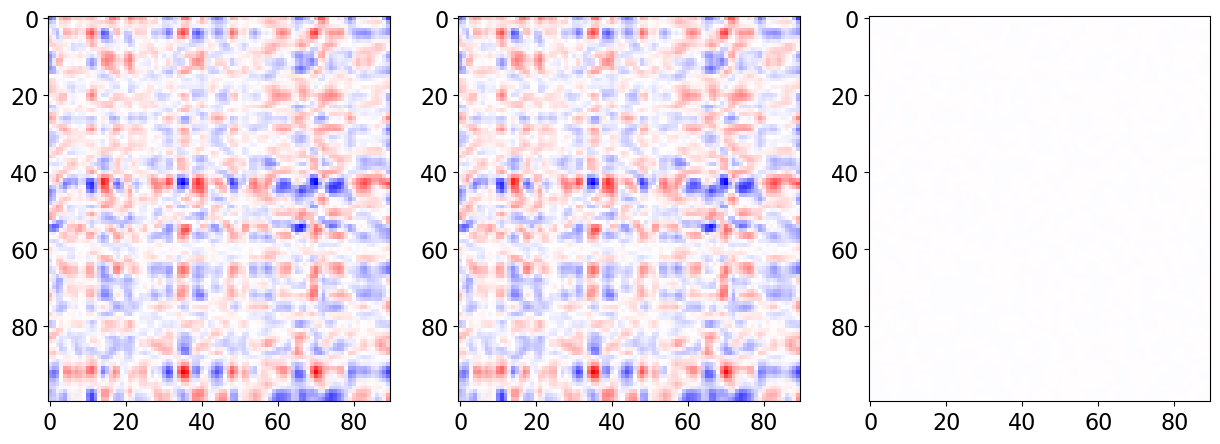

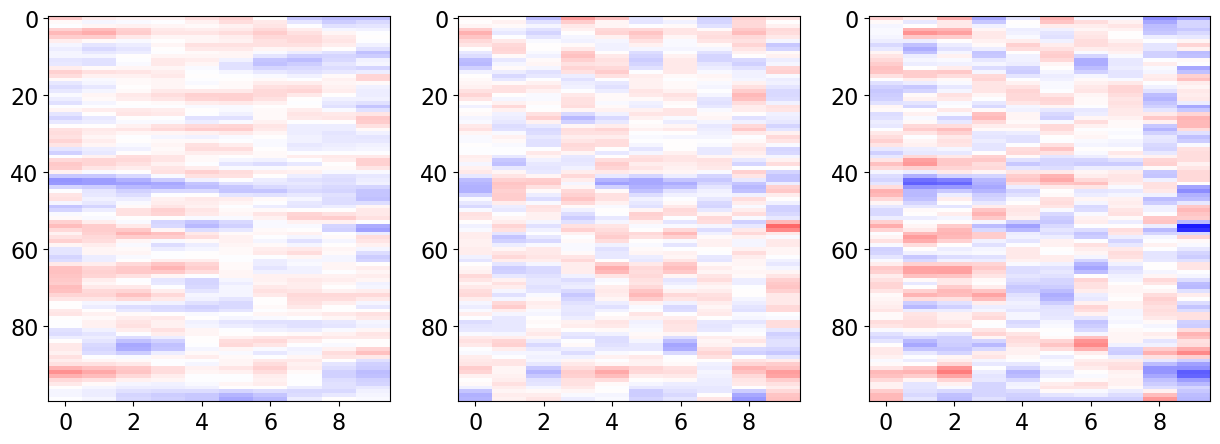

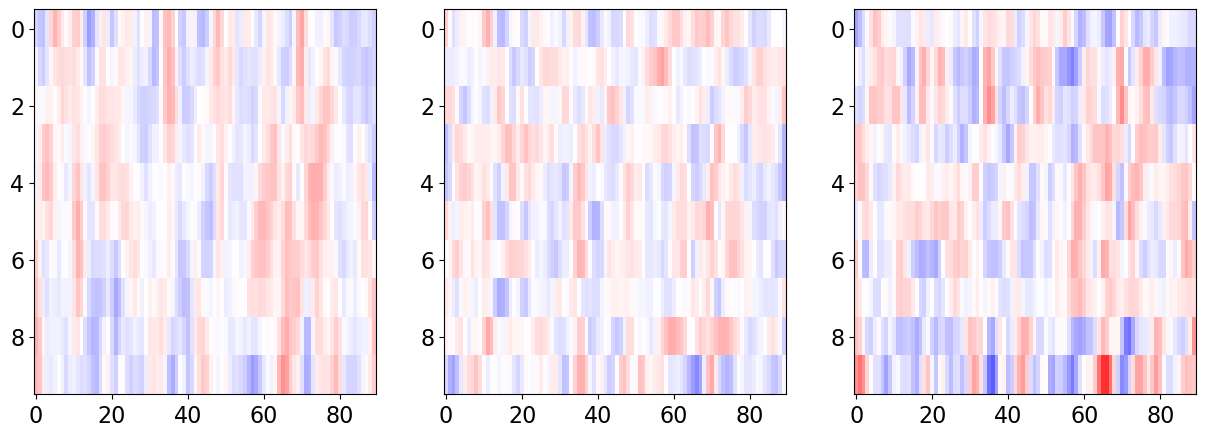

In [8]:
# easy, close to X and Y
#Xin = np.random.normal(0, 0.2, (n, k)) + X
#Yin = np.random.normal(0, 0.2, (k, m)) + Y

# hard, random
Xin = np.random.normal(0, 1, (n, k))
Yin = np.random.normal(0, 1, (k, m))

sigma = 0.1
hop = LowRankFactorizedMatrix([Xin.copy(), Yin.copy()], A.ravel())
l2f = L2(sigma=sigma)
l2g = L2(sigma=sigma)

xsest = GeneralizedPALM(hop, [l2f, l2g], x0s=[Xin.ravel(), Yin.ravel()], 
                        gammafs=[2, 2], niter=500, acceleration='fista', show=True)
xest, yest = xsest[0], xsest[1]
Xest, Yest = xest.reshape(n, k), yest.reshape(k, m)
Aest = Xest @ Yest

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(A, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Aest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(A-Aest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(X, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Xest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(X-Xest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(Y, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Yest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(Y-Yest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

Generalized PALM algorithm
---------------------------------------------------------
Bilinear operator: <class '__main__.LowRankFactorizedMatrix'>
Proximal operator (f0): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (f1): <class 'pyproximal.proximal.L2.L2'>
gammafs = None	niter = 400

   Itn      x[0][0]        f0      f1      H
     0    4.81948e-01   6.75e+00   3.58e+01   2.79550e+03
     1    2.91186e-01   4.53e+00   3.39e+01   1.27677e+03
     2    2.05234e-01   4.02e+00   3.33e+01   9.97219e+02
     3    1.66567e-01   3.84e+00   3.30e+01   8.74061e+02
     4    1.50209e-01   3.79e+00   3.28e+01   7.82789e+02
     5    1.46016e-01   3.79e+00   3.28e+01   6.95504e+02
     6    1.49680e-01   3.85e+00   3.28e+01   6.08047e+02
     7    1.58701e-01   3.93e+00   3.29e+01   5.25926e+02
     8    1.70820e-01   4.02e+00   3.30e+01   4.56873e+02
     9    1.83836e-01   4.11e+00   3.31e+01   4.04476e+02
    40    3.48049e-01   4.59e+00   3.11e+01   7.71696e+01
    80    3.66011e-01 

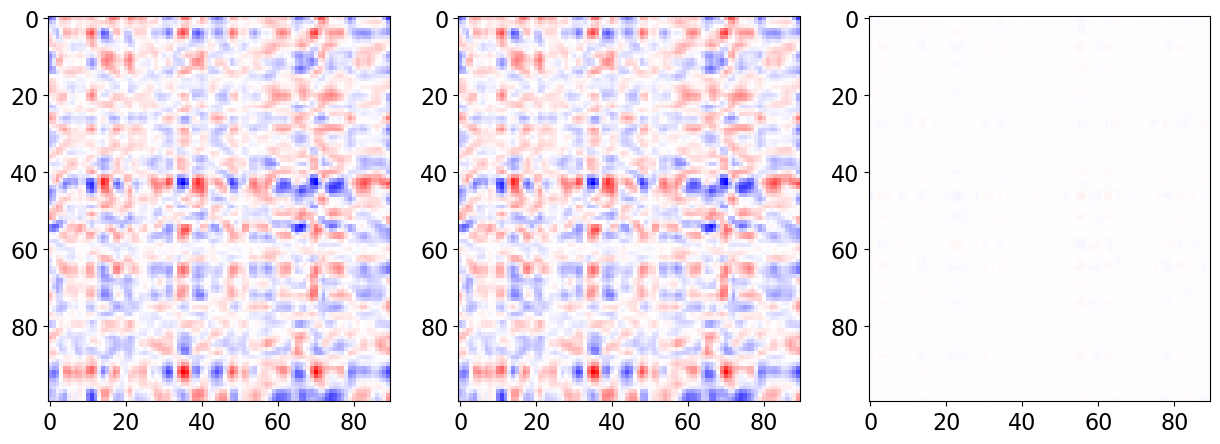

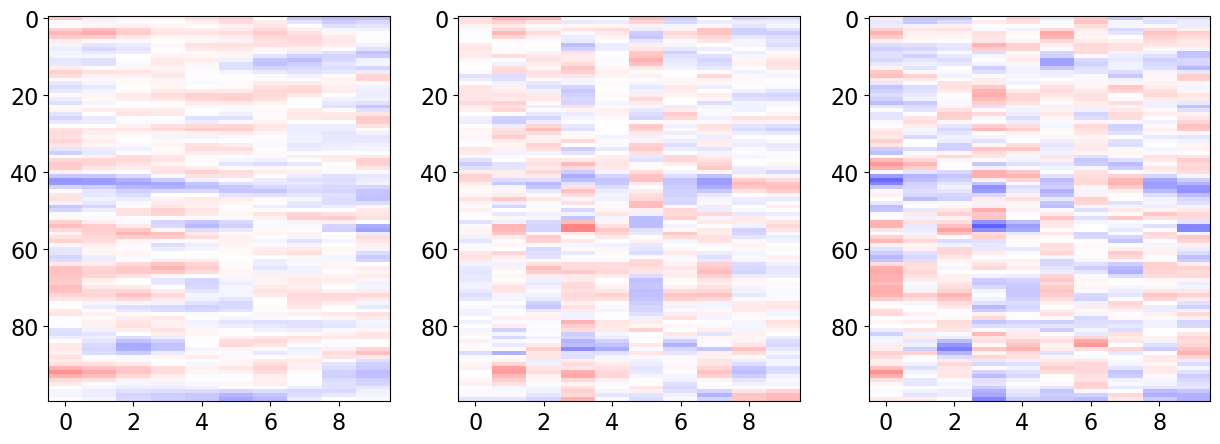

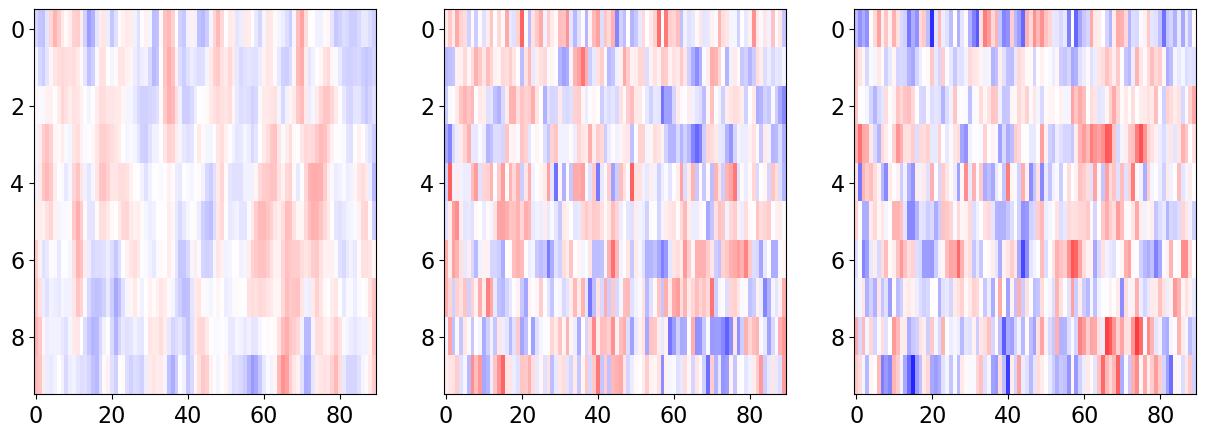

In [9]:
# Using back-tracking

# easy, close to X and Y
#Xin = np.random.normal(0, 0.2, (n, k)) + X
#Yin = np.random.normal(0, 0.2, (k, m)) + Y

# hard, random
Xin = np.random.normal(0, 1, (n, k))
Yin = np.random.normal(0, 1, (k, m))

sigma = 0.1
hop = LowRankFactorizedMatrix([Xin.copy(), Yin.copy()], A.ravel())
l2f = L2(sigma=sigma)
l2g = L2(sigma=sigma)

xsest = GeneralizedPALM(hop, [l2f, l2g], x0s=[Xin.ravel(), Yin.ravel()], 
                        gammafs=None, niter=400, niterback=100, beta=0.5,
                        acceleration=None, show=True)
xest, yest = xsest[0], xsest[1]
Xest, Yest = xest.reshape(n, k), yest.reshape(k, m)
Aest = Xest @ Yest

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(A, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Aest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(A-Aest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(X, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Xest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(X-Xest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(Y, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Yest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(Y-Yest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

PALM algorithm
---------------------------------------------------------
Bilinear operator: <class 'pyproximal.utils.bilinear.LowRankFactorizedMatrix'>
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L2.L2'>
gammaf = 2	gammag = 2	niter = 500

   Itn      x[0]       y[0]        f         g         H         ck         dk
     1  -5.62814e-01  5.37e-01  3.53e+01  3.06e+01  2.13e+04  5.59e+02  4.68e+02
     2  -4.98214e-01  4.93e-01  2.61e+01  2.31e+01  1.13e+04  4.11e+02  3.54e+02
     3  -4.42106e-01  4.78e-01  2.01e+01  1.82e+01  6.35e+03  3.18e+02  2.85e+02
     4  -3.96693e-01  4.79e-01  1.63e+01  1.51e+01  3.89e+03  2.62e+02  2.43e+02
     5  -3.61583e-01  4.88e-01  1.38e+01  1.32e+01  2.61e+03  2.29e+02  2.19e+02
     6  -3.35099e-01  5.01e-01  1.23e+01  1.20e+01  1.91e+03  2.10e+02  2.06e+02
     7  -3.15205e-01  5.15e-01  1.13e+01  1.13e+01  1.51e+03  2.00e+02  1.98e+02
     8  -3.00043e-01  5.30e-01  1.07e+01  1.07e+0

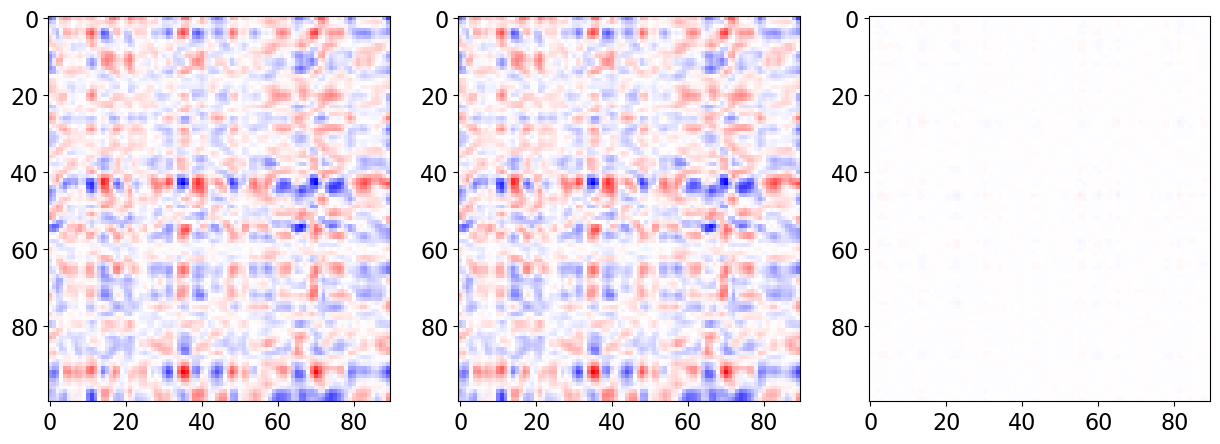

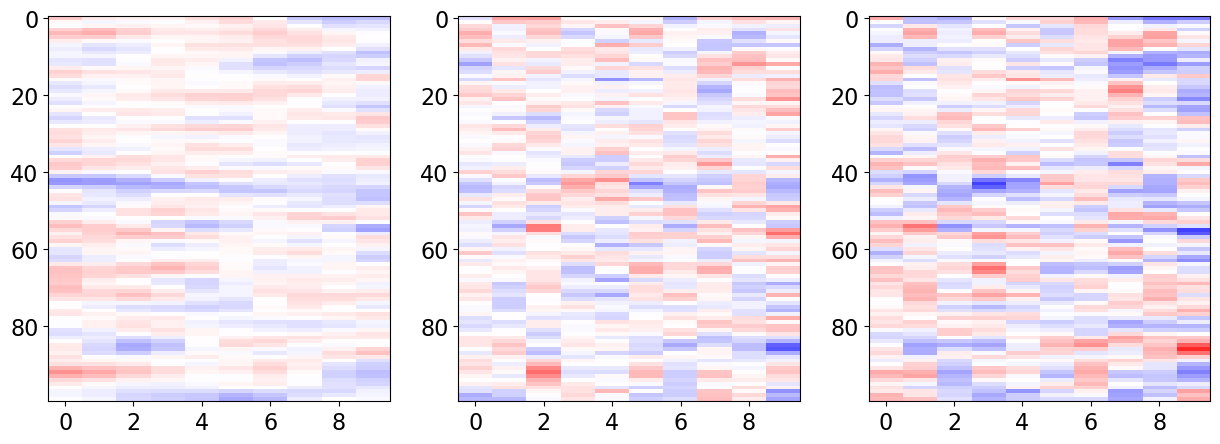

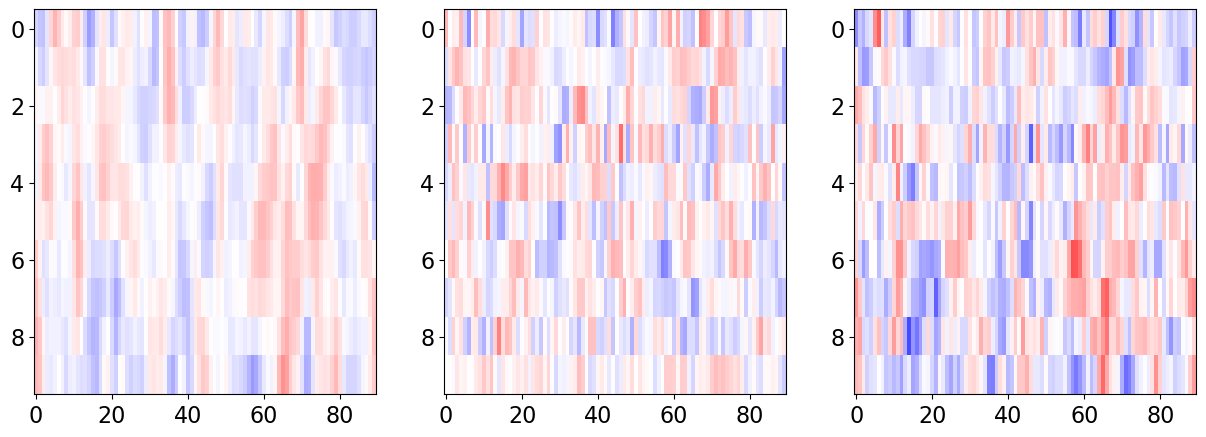

In [10]:
# easy, close to X and Y (PALM)
#Xin = np.random.normal(0, 0.2, (n, k)) + X
#Yin = np.random.normal(0, 0.2, (k, m)) + Y

# hard, random
Xin = np.random.normal(0, 1, (n, k))
Yin = np.random.normal(0, 1, (k, m))

sigma = 0.1
hop = pyproxLowRankFactorizedMatrix(Xin.copy(), Yin.copy(), A.ravel())
l2f = L2(sigma=sigma)
l2g = L2(sigma=sigma)

xsest = PALM(hop, l2f, l2g, x0=Xin.ravel(), y0=Yin.ravel(), 
             gammaf=2, gammag=2, niter=500,  show=True)
xest, yest = xsest[0], xsest[1]
Xest, Yest = xest.reshape(n, k), yest.reshape(k, m)
Aest = Xest @ Yest

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(A, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Aest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(A-Aest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(X, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Xest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(X-Xest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(Y, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Yest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(Y-Yest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

PALM algorithm
---------------------------------------------------------
Bilinear operator: <class 'pyproximal.utils.bilinear.LowRankFactorizedMatrix'>
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L2.L2'>
gammaf = None	gammag = None	niter = 500

   Itn      x[0]       y[0]        f         g         H         ck         dk
     1  -4.45938e-01  -4.66e-01  9.08e+00  3.17e+01  2.99e+03  0.00e+00  0.00e+00
     2  -3.31143e-01  -4.17e-01  6.69e+00  2.98e+01  1.30e+03  0.00e+00  0.00e+00
     3  -2.84237e-01  -4.00e-01  6.17e+00  2.92e+01  1.01e+03  0.00e+00  0.00e+00
     4  -2.58110e-01  -3.94e-01  6.01e+00  2.90e+01  8.90e+02  0.00e+00  0.00e+00
     5  -2.42080e-01  -3.90e-01  5.98e+00  2.89e+01  8.01e+02  0.00e+00  0.00e+00
     6  -2.31757e-01  -3.88e-01  6.01e+00  2.90e+01  7.15e+02  0.00e+00  0.00e+00
     7  -2.25632e-01  -3.86e-01  6.08e+00  2.91e+01  6.26e+02  0.00e+00  0.00e+00
     8  -2.23690e-01  -3.83e-01  6.1

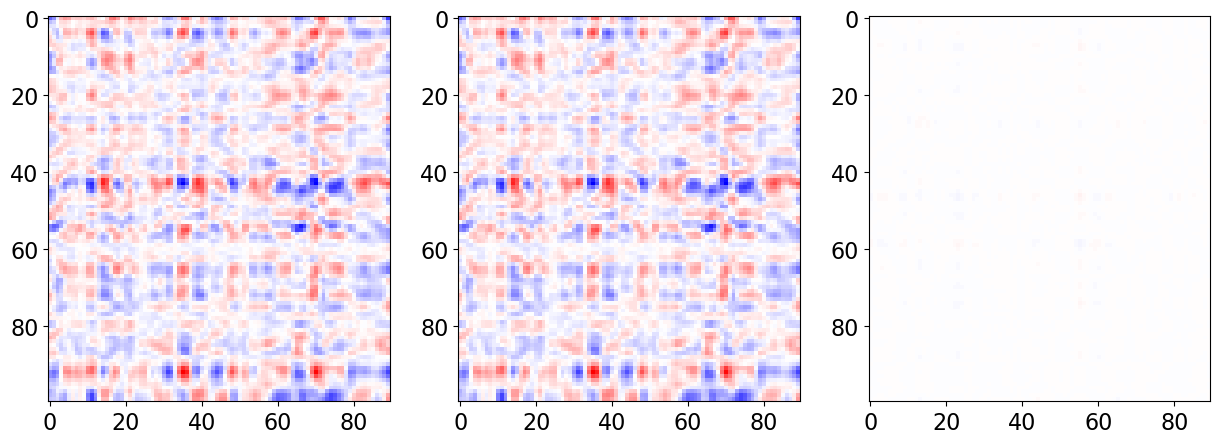

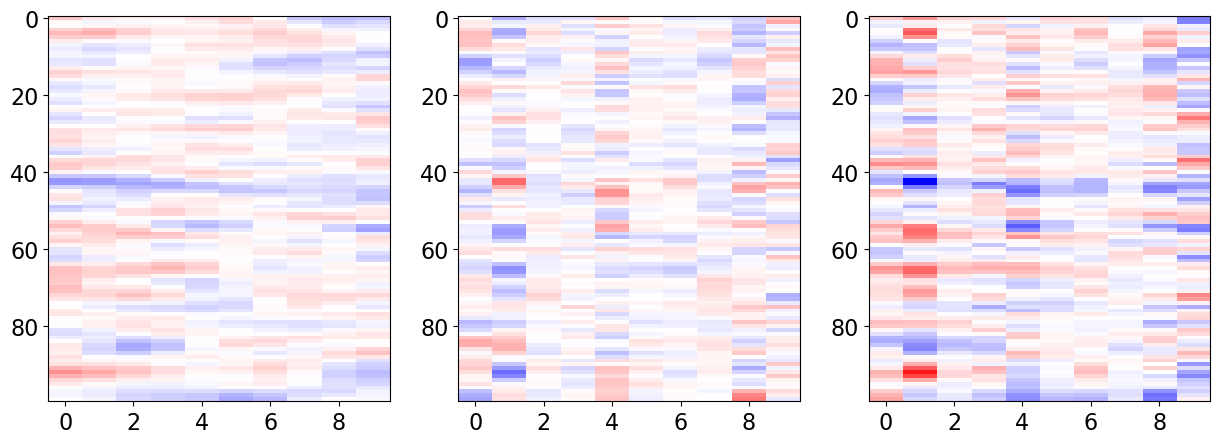

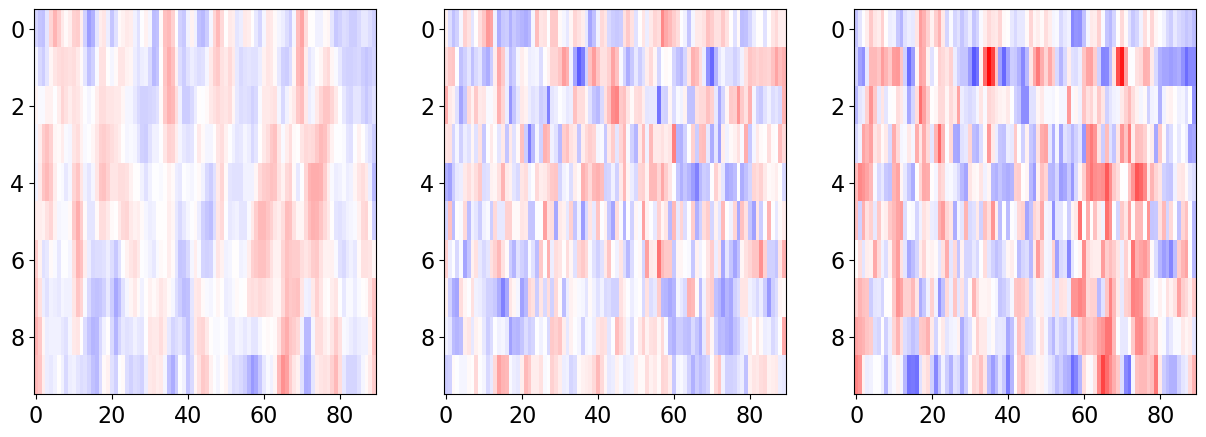

In [11]:
# Using back-tracking

# easy, close to X and Y (PALM)
#Xin = np.random.normal(0, 0.2, (n, k)) + X
#Yin = np.random.normal(0, 0.2, (k, m)) + Y

# hard, random
Xin = np.random.normal(0, 1, (n, k))
Yin = np.random.normal(0, 1, (k, m))

sigma = 0.1
hop = pyproxLowRankFactorizedMatrix(Xin.copy(), Yin.copy(), A.ravel())
l2f = L2(sigma=sigma)
l2g = L2(sigma=sigma)

xsest = PALM(hop, l2f, l2g, x0=Xin.ravel(), y0=Yin.ravel(), 
             gammaf=None, gammag=None, niter=500,  show=True)
xest, yest = xsest[0], xsest[1]
Xest, Yest = xest.reshape(n, k), yest.reshape(k, m)
Aest = Xest @ Yest

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(A, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Aest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(A-Aest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(X, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Xest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(X-Xest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(Y, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Yest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(Y-Yest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

Generalized PALM algorithm
---------------------------------------------------------
Bilinear operator: <class '__main__.LowRankFactorizedMatrix'>
Proximal operator (f0): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (f1): <class 'pyproximal.proximal.L2.L2'>
gammafs = None	niter = 5000

   Itn      x[0][0]        f0      f1      H
     0    1.41374e+00   2.72e+01   3.01e+01   1.35521e+03
     1    1.23129e+00   2.37e+01   2.54e+01   6.59111e+02
     2    1.12325e+00   2.21e+01   2.30e+01   4.23925e+02
     3    1.04419e+00   2.12e+01   2.14e+01   3.10414e+02
     4    9.83252e-01   2.05e+01   2.03e+01   2.45282e+02
     5    9.34466e-01   2.01e+01   1.95e+01   2.03652e+02
     6    8.94567e-01   1.97e+01   1.89e+01   1.74999e+02
     7    8.61432e-01   1.94e+01   1.84e+01   1.54170e+02
     8    8.33590e-01   1.92e+01   1.79e+01   1.38376e+02
     9    8.09963e-01   1.90e+01   1.76e+01   1.25991e+02
   500    -1.46957e-01   7.36e+00   4.98e+00   1.88770e+00
  1000    -4.40878e-

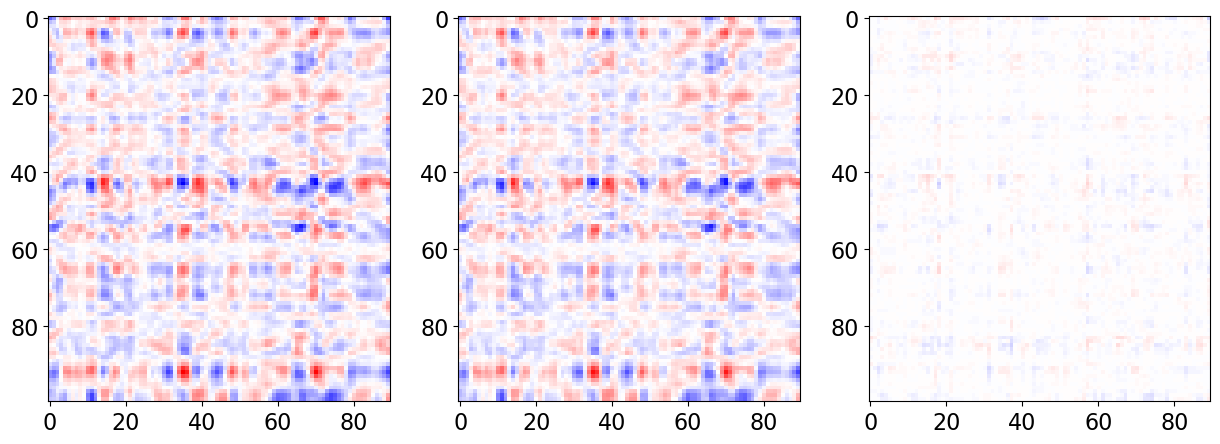

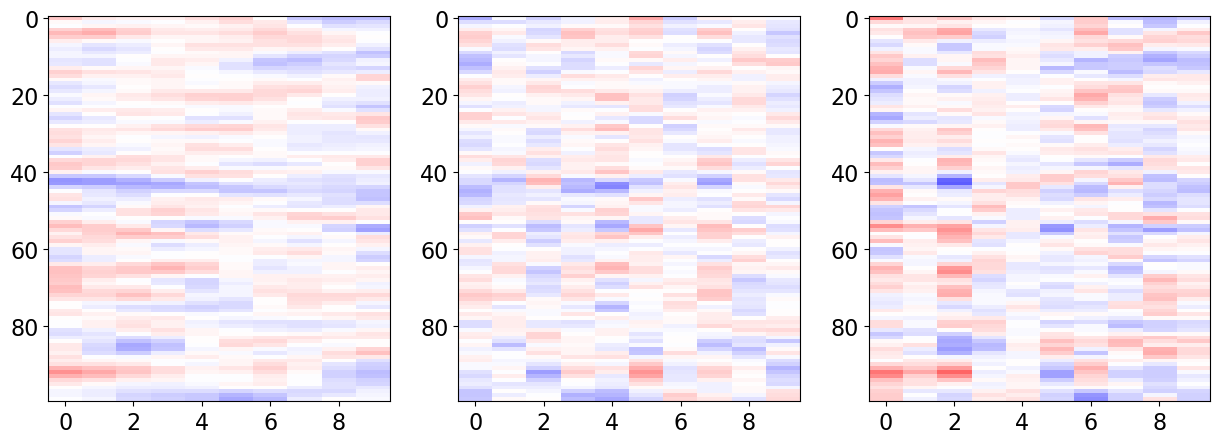

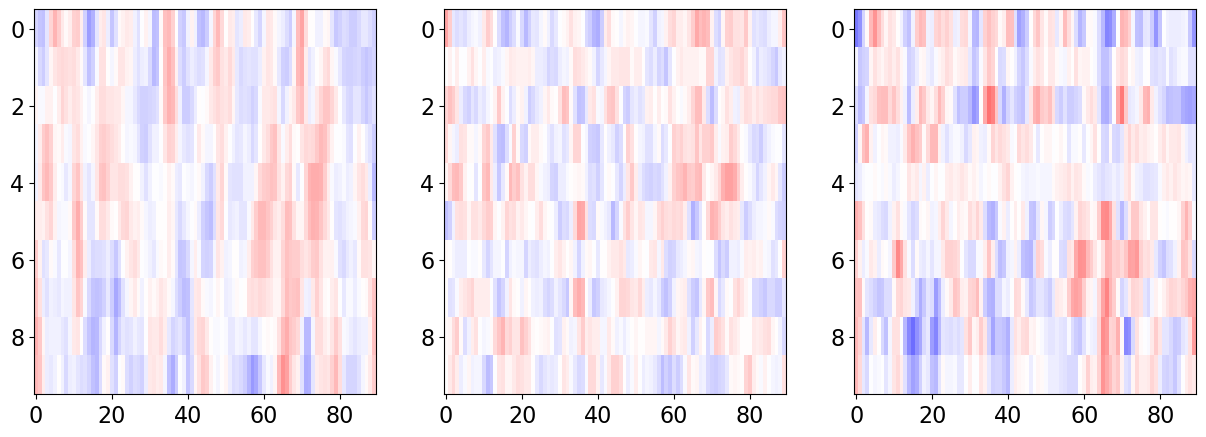

In [12]:
# Adding ROp and using back-tracking

# easy, close to X and Y
#Xin = np.random.normal(0, 0.2, (n, k)) + X
#Yin = np.random.normal(0, 0.2, (k, m)) + Y

# hard, random
Xin = np.random.normal(0, 1, (n, k))
Yin = np.random.normal(0, 1, (k, m))

sub = 0.2
nsub = int(n*m*sub)
iava = np.random.permutation(np.arange(n*m))[:nsub]
Rop = Restriction(n*m, iava)

sigma = 0.1
hop = LowRankFactorizedMatrix([Xin.copy(), Yin.copy()], Rop @ A.ravel(), Rop)
l2f = L2(sigma=sigma)
l2g = L2(sigma=sigma)

xsest = GeneralizedPALM(hop, [l2f, l2g], x0s=[Xin.ravel(), Yin.ravel()], 
                        gammafs=None, niter=5000, niterback=100, beta=0.5,
                        acceleration=None, show=True)
xest, yest = xsest[0], xsest[1]
Xest, Yest = xest.reshape(n, k), yest.reshape(k, m)
Aest = Xest @ Yest

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(A, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Aest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(A-Aest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(X, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Xest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(X-Xest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(Y, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Yest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(Y-Yest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

PALM algorithm
---------------------------------------------------------
Bilinear operator: <class 'pyproximal.utils.bilinear.LowRankFactorizedMatrix'>
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L2.L2'>
gammaf = None	gammag = None	niter = 5000

   Itn      x[0]       y[0]        f         g         H         ck         dk
     1  -4.75965e-02  4.17e-01  3.17e+01  2.52e+01  1.22e+03  0.00e+00  0.00e+00
     2  1.54360e-01  3.48e-01  2.85e+01  2.09e+01  5.92e+02  0.00e+00  0.00e+00
     3  2.67840e-01  2.94e-01  2.70e+01  1.86e+01  3.79e+02  0.00e+00  0.00e+00
     4  3.41653e-01  2.49e-01  2.61e+01  1.71e+01  2.76e+02  0.00e+00  0.00e+00
     5  3.93747e-01  2.09e-01  2.55e+01  1.61e+01  2.17e+02  0.00e+00  0.00e+00
     6  4.32673e-01  1.73e-01  2.50e+01  1.54e+01  1.79e+02  0.00e+00  0.00e+00
     7  4.63069e-01  1.41e-01  2.47e+01  1.48e+01  1.54e+02  0.00e+00  0.00e+00
     8  4.87608e-01  1.12e-01  2.44e+01  1.43e+0

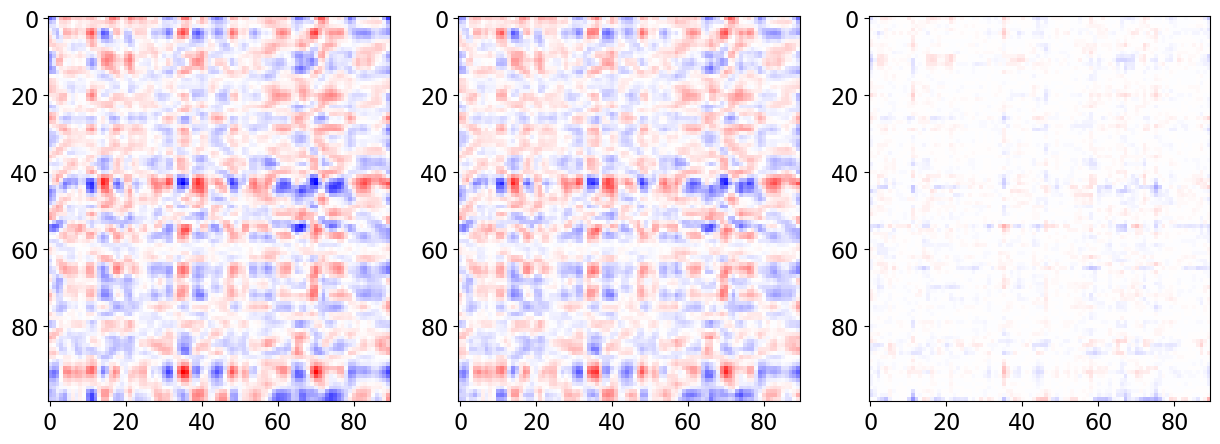

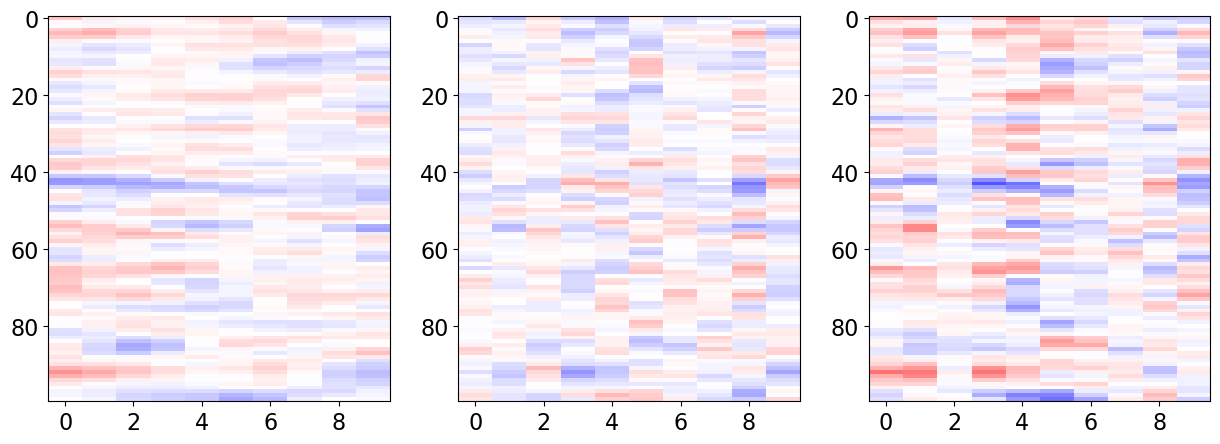

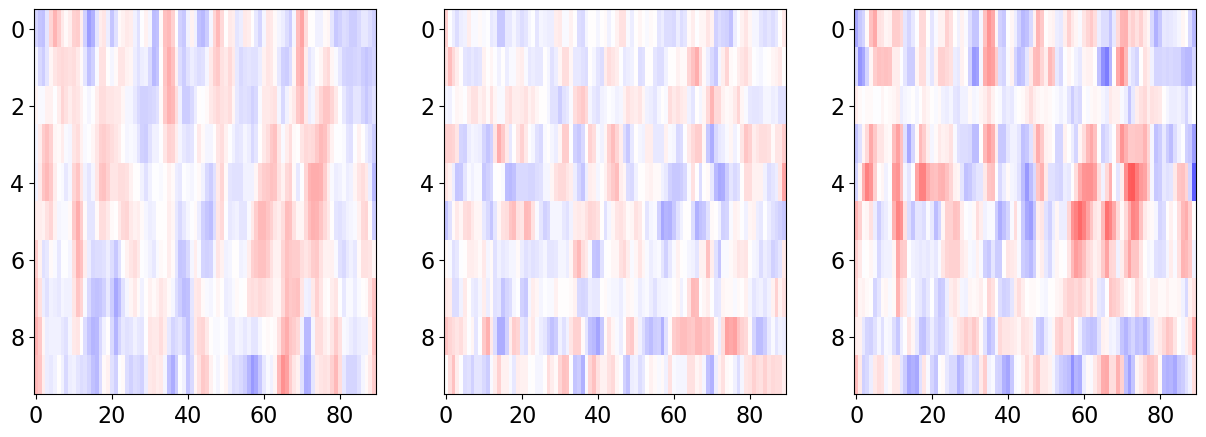

In [13]:
# Adding ROp and using back-tracking

# easy, close to X and Y
#Xin = np.random.normal(0, 0.2, (n, k)) + X
#Yin = np.random.normal(0, 0.2, (k, m)) + Y

# hard, random
Xin = np.random.normal(0, 1, (n, k))
Yin = np.random.normal(0, 1, (k, m))

sub = 0.2
nsub = int(n*m*sub)
iava = np.random.permutation(np.arange(n*m))[:nsub]
Rop = Restriction(n*m, iava)

sigma = 0.1
hop = pyproxLowRankFactorizedMatrix(Xin.copy(), Yin.copy(), Rop @ A.ravel(), Rop)
l2f = L2(sigma=sigma)
l2g = L2(sigma=sigma)

xsest = PALM(hop, l2f, l2g, x0=Xin.ravel(), y0=Yin.ravel(), 
             gammaf=None, gammag=None, niter=5000, show=True)
xest, yest = xsest[0], xsest[1]
Xest, Yest = xest.reshape(n, k), yest.reshape(k, m)
Aest = Xest @ Yest

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(A, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Aest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(A-Aest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(X, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Xest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(X-Xest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(Y, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Yest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(Y-Yest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');